# L.A. County places and U.S. Census tracts

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
import json
import numpy as np
import altair as alt
import altair_latimes as lat

In [4]:
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
from datetime import datetime, date

In [5]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

### Get tracts

In [6]:
src_tracts = gpd.read_file(
    "input/la_county_gis_2010_tracts_demographics_1566095293689.geojson"
)

In [7]:
src_tracts.columns = (
    src_tracts.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("/", "_", regex=False)
)

In [8]:
src_tracts = src_tracts.to_crs("EPSG:3311")

In [9]:
src_tracts["tract_area"] = round(src_tracts["geometry"].area / 2.59e6, 2)

In [10]:
src_tracts.head(1)

objectid    ct10    label                                   documentation  \
0         1  911001  9110.01  http://www.census.gov/prod/cen2010/doc/sf1.pdf   

   p0010001  p0030001  p0030002  p0030003  p0030004  p0030005  p0030006  \
0      4201      4201      3167       161        39       100        16   

   p0030007  p0030008  p0040001  p0040002  p0040003  p0050001  p0050002  \
0       564       154      4201      3101      1100      4201      3101   

   p0050003  p0050004  p0050005  p0050006  p0050007  p0050008  p0050009  ...  \
0      2718       154        19        99        15        11        85  ...   

   h0050005  h0050006  h0050007  h0050008  h0100001  h0130001  h0130002  \
0        18       150         0       117      4170      1673       462   

   h0130003  h0130004  h0130005  h0130006  h0130007  h0130008  medhinc  \
0       615       254       171        75        49        47  53266.0   

   ages_0_9  ages_10_19  ages_20_29  ages_30_39  ages_40_49  ages_50_59  \
0       386         529         421         378         561         843   

   ages_60_69  ages_70_79  ages_80_over  \
0         629         310           144   

                                            geometry  tract_area  
0  POLYGON ((213976.330 -381619.846, 210741.685 -...      144.42  

[1 rows x 393 columns]

### Slim down the dataframe

In [11]:
latracts = gpd.GeoDataFrame(
    src_tracts[
        [
            "ct10",
            "geometry",
            "medhinc",
            "p0010001",
            "p0040003",
            "p0050003",
            "p0030003",
            "p0030005",
            "h0130001",
            "h0130008",
            "h0130002",
            "tract_area",
        ]
    ]
)

In [12]:
latracts.rename(
    columns={
        "ct10": "tract",
        "medhinc": "median_house_income",
        "p0010001": "pop",
        "p0040003": "latino",
        "p0050003": "anglo",
        "p0030003": "black",
        "p0030005": "asian",
        "h0130001": "total_housing_units",
        "h0130002": "total_single_units",
        "h0130008": "total_seven_more_units",
    },
    inplace=True,
)

In [13]:
latracts.head()

tract                                           geometry  \
0  911001  POLYGON ((213976.330 -381619.846, 210741.685 -...   
1  576301  POLYGON ((168127.093 -468669.018, 168065.670 -...   
2  670500  POLYGON ((154461.782 -470115.198, 154395.696 -...   
3  651302  POLYGON ((152392.404 -466321.539, 152309.892 -...   
4  575402  POLYGON ((167708.997 -467871.765, 167626.384 -...   

   median_house_income   pop  latino  anglo  black  asian  \
0              53266.0  4201    1100   2718    161    100   
1              32288.0  4176    2137    615    845    470   
2             219688.0  1860     102   1379     29    303   
3             102727.0  6311     605   4260     60   1121   
4              28782.0  4065    3132    150    511    172   

   total_housing_units  total_seven_more_units  total_single_units  tract_area  
0                 1673                      47                 462      144.42  
1                 1590                      51                 579        0.21  
2                  663                      14                  98        2.99  
3                 2484                       9                 537        0.93  
4                  954                      99                 111        0.13

### Export geojson

In [14]:
latracts.to_file("output/latracts_3311.geojson", driver="GeoJSON")

---

### Tracts population

In [15]:
tracts_src = pd.read_csv(
    "/Users/mhustiles/data/github/census-data-downloader/\
processed/acs5_2018_population_tracts.csv",
    dtype={"geoid": "str", "tract": "str", "state": str, "county": str},
)

In [16]:
ca_tracts = tracts_src[tracts_src["name"].str.contains(", California")]

In [17]:
ca_tracts.head()

geoid                                               name  \
3560  06059052511     Census Tract 525.11, Orange County, California   
3561  06037127520  Census Tract 1275.20, Los Angeles County, Cali...   
3562  06107001400         Census Tract 14, Tulare County, California   
3563  06067008113  Census Tract 81.13, Sacramento County, California   
3564  06071000824  Census Tract 8.24, San Bernardino County, Cali...   

      universe  universe_annotation  universe_moe universe_moe_annotation  \
3560    6295.0                  NaN         404.0                     NaN   
3561    4544.0                  NaN         368.0                     NaN   
3562    5202.0                  NaN         456.0                     NaN   
3563    3626.0                  NaN         215.0                     NaN   
3564    5401.0                  NaN         393.0                     NaN   

     state county   tract  
3560    06    059  052511  
3561    06    037  127520  
3562    06    107  001400  
3563    06    067  008113  
3564    06    071  000824

In [18]:
tracts_geo = pd.merge(latracts, ca_tracts, on="tract")

In [19]:
tracts_geo.rename(
    columns={"name_x": "placename", "universe": "population"}, inplace=True
)

In [20]:
tracts_geo.head()

tract                                           geometry  \
0  911001  POLYGON ((213976.330 -381619.846, 210741.685 -...   
1  576301  POLYGON ((168127.093 -468669.018, 168065.670 -...   
2  670500  POLYGON ((154461.782 -470115.198, 154395.696 -...   
3  651302  POLYGON ((152392.404 -466321.539, 152309.892 -...   
4  575402  POLYGON ((167708.997 -467871.765, 167626.384 -...   

   median_house_income   pop  latino  anglo  black  asian  \
0              53266.0  4201    1100   2718    161    100   
1              32288.0  4176    2137    615    845    470   
2             219688.0  1860     102   1379     29    303   
3             102727.0  6311     605   4260     60   1121   
4              28782.0  4065    3132    150    511    172   

   total_housing_units  total_seven_more_units  total_single_units  \
0                 1673                      47                 462   
1                 1590                      51                 579   
2                  663                      14                  98   
3                 2484                       9                 537   
4                  954                      99                 111   

   tract_area        geoid                                               name  \
0      144.42  06037911001  Census Tract 9110.01, Los Angeles County, Cali...   
1        0.21  06037576301  Census Tract 5763.01, Los Angeles County, Cali...   
2        2.99  06037670500  Census Tract 6705, Los Angeles County, California   
3        0.93  06037651302  Census Tract 6513.02, Los Angeles County, Cali...   
4        0.13  06037575402  Census Tract 5754.02, Los Angeles County, Cali...   

   population  universe_annotation  universe_moe universe_moe_annotation  \
0      4380.0                  NaN         555.0                     NaN   
1      3990.0                  NaN         330.0                     NaN   
2      1630.0                  NaN         147.0                     NaN   
3      6032.0                  NaN         395.0                     NaN   
4      4113.0                  NaN         299.0                     NaN   

  state county  
0    06    037  
1    06    037  
2    06    037  
3    06    037  
4    06    037

In [21]:
tracts_geo.drop(
    ["universe_annotation", "universe_moe", "universe_moe_annotation"],
    axis=1,
    inplace=True,
)

In [22]:
tracts_geo.head()

tract                                           geometry  \
0  911001  POLYGON ((213976.330 -381619.846, 210741.685 -...   
1  576301  POLYGON ((168127.093 -468669.018, 168065.670 -...   
2  670500  POLYGON ((154461.782 -470115.198, 154395.696 -...   
3  651302  POLYGON ((152392.404 -466321.539, 152309.892 -...   
4  575402  POLYGON ((167708.997 -467871.765, 167626.384 -...   

   median_house_income   pop  latino  anglo  black  asian  \
0              53266.0  4201    1100   2718    161    100   
1              32288.0  4176    2137    615    845    470   
2             219688.0  1860     102   1379     29    303   
3             102727.0  6311     605   4260     60   1121   
4              28782.0  4065    3132    150    511    172   

   total_housing_units  total_seven_more_units  total_single_units  \
0                 1673                      47                 462   
1                 1590                      51                 579   
2                  663                      14                  98   
3                 2484                       9                 537   
4                  954                      99                 111   

   tract_area        geoid                                               name  \
0      144.42  06037911001  Census Tract 9110.01, Los Angeles County, Cali...   
1        0.21  06037576301  Census Tract 5763.01, Los Angeles County, Cali...   
2        2.99  06037670500  Census Tract 6705, Los Angeles County, California   
3        0.93  06037651302  Census Tract 6513.02, Los Angeles County, Cali...   
4        0.13  06037575402  Census Tract 5754.02, Los Angeles County, Cali...   

   population state county  
0      4380.0    06    037  
1      3990.0    06    037  
2      1630.0    06    037  
3      6032.0    06    037  
4      4113.0    06    037

---

### Get L.A. County places

In [23]:
places_geo = gpd.read_file(
    "input/cities-neighborhoods-unincorporated-la-county.geojson"
).fillna("")

In [24]:
places_geo = places_geo.to_crs("EPSG:3311")

In [25]:
places_geo.columns = places_geo.columns.str.lower()

In [26]:
# places_geo["NAME"] = np.where(
#     (places_geo["LCITY"] == "Los Angeles") | (places_geo["LCITY"] == "Unincorporated"),
#     places_geo["COMMUNITY"],
#     places_geo["LCITY"],
# )

In [27]:
len(places_geo)

348

In [28]:
# places_geo.drop(
#     [
#         "LCITY",
#         "LABEL",
#         "COMMUNITY",
#         "CONFIRMED",
#         "SUSPECTED",
#         "RECOVERED",
#         "DEATHS",
#         "Shape__Area",
#         "Shape__Length",
#         "OBJECTID",
#     ],
#     axis=1,
#     inplace=True,
# )

In [29]:
places_geo["place_area"] = round(places_geo["geometry"].area / 2.59e6, 2)

In [30]:
places_geo.head()

name                                           geometry  \
0   Agoura Hills  MULTIPOLYGON (((117201.354 -426752.672, 116472...   
1     Bellflower  MULTIPOLYGON (((174818.350 -454427.122, 174810...   
2  Beverly Hills  MULTIPOLYGON (((148374.547 -432436.704, 148309...   
3        Burbank  MULTIPOLYGON (((156006.516 -426897.025, 156303...   
4      Calabasas  MULTIPOLYGON (((120408.368 -426638.916, 120344...   

   place_area  
0        7.82  
1        6.18  
2        5.71  
3       17.34  
4       13.76

In [31]:
places_geo.to_file("output/places_geo_3311.geojson", driver="GeoJSON")

---

### What pct of each tract is in each place? 

In [32]:
merged_df = gpd.sjoin(latracts, places_geo)

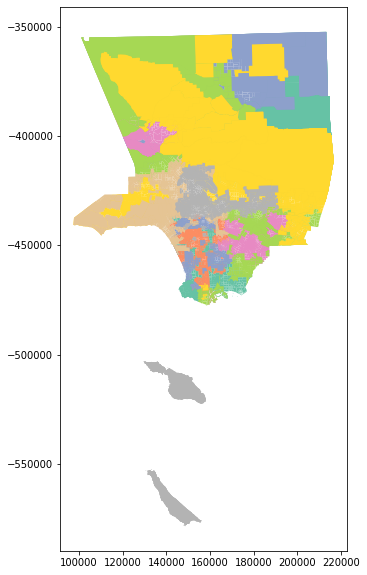

In [33]:
merged_df.plot(figsize=(10, 10), cmap="Set2")

In [34]:
merged_df.iloc[1]

tract                                                                106111
geometry                  POLYGON ((147145.3370746166 -409906.2143853167...
median_house_income                                                   80536
pop                                                                    4334
latino                                                                 2552
anglo                                                                  1194
black                                                                   221
asian                                                                   326
total_housing_units                                                    1313
total_seven_more_units                                                   68
total_single_units                                                      179
tract_area                                                             1.48
index_right                                                             146
name        

In [35]:
merged_df[merged_df["name"] == "Playa Del Rey"]

tract                                           geometry  \
872   278102  MULTIPOLYGON (((144133.026 -448658.405, 144342...   
932   702901  POLYGON ((143994.762 -446826.491, 143977.132 -...   
934   274202  MULTIPOLYGON (((142134.995 -447414.423, 142131...   
1147  276603  POLYGON ((144972.939 -449811.561, 144881.093 -...   
1184  980028  POLYGON ((149210.424 -449853.802, 149154.564 -...   
1253  276601  POLYGON ((145471.899 -448743.439, 145457.759 -...   

      median_house_income   pop  latino  anglo  black  asian  \
872              110845.0  3158     282   2465    139    154   
932               86326.0  8866     686   6624    465    749   
934              115972.0  4337     274   3560    158    218   
1147              97475.0  5252     558   3471    328    626   
1184                  NaN     4       2      0      2      0   
1253             130962.0  3838     450   2522    189    505   

      total_housing_units  total_seven_more_units  total_single_units  \
872                  1595                       7                 605   
932                  5600                       2                3037   
934                  2438                       1                1105   
1147                 3128                       1                1563   
1184                    1                       0                   1   
1253                 1683                       8                 484   

      tract_area  index_right           name  place_area  
872         0.70           43  Playa Del Rey        0.67  
932         1.45           43  Playa Del Rey        0.67  
934         0.48           43  Playa Del Rey        0.67  
1147        0.18           43  Playa Del Rey        0.67  
1184        6.70           43  Playa Del Rey        0.67  
1253        0.86           43  Playa Del Rey        0.67

### Which areas of LA are the places in? 

In [36]:
nsas = pd.read_csv("../../mapping-la-pipeline/data/crosswalk/nsa_list.csv")

In [37]:
merged = pd.merge(merged_df, nsas, left_on="name", right_on="nsa", how="left")

### Add in some missing values

In [38]:
merged.loc[merged["name"] == "Playa Del Rey", "nsa"] = "Playa Del Rey"
merged.loc[merged["name"] == "Playa Del Rey", "rsa"] = "Westside"
merged.loc[merged["name"] == "Palisades Highlands", "nsa"] = "Palisades Highlands"
merged.loc[merged["name"] == "Palisades Highlands", "rsa"] = "Westside"

---

### Get the share of the tract that's within its parent neighborhood

In [39]:
def get_tract_share(row):
    tract_shape = tracts_geo[tracts_geo.tract == row["tract"]].iloc[0].geometry
    hood_shape = places_geo[places_geo.name == row["name"]].iloc[0].geometry
    intersection = tract_shape.intersection(hood_shape)
    tract_area = tract_shape.area
    intersection_area = intersection.area
    return intersection_area / tract_area

In [40]:
merged["tract_percent"] = round(merged.apply(get_tract_share, axis=1), 5)

In [41]:
merged = merged.sort_values("tract_percent", ascending=False)

In [42]:
merged["est_pop"] = merged["pop"] * merged["tract_percent"]
merged["est_latino"] = merged["latino"] * merged["tract_percent"]
merged["est_anglo"] = merged["anglo"] * merged["tract_percent"]
merged["est_black"] = merged["black"] * merged["tract_percent"]
merged["est_asian"] = merged["asian"] * merged["tract_percent"]

In [43]:
merged["est_total_seven_more_units"] = (
    merged["total_seven_more_units"] * merged["tract_percent"]
)
merged["est_total_single_units"] = (
    merged["total_single_units"] * merged["tract_percent"]
)
merged["est_total_housing_units"] = (
    merged["total_housing_units"] * merged["tract_percent"]
)

In [44]:
merged[merged["name"].str.contains("Rey")].head()

tract                                           geometry  \
4559  269700  POLYGON ((149307.010 -440475.881, 149206.088 -...   
4269  278102  MULTIPOLYGON (((144133.026 -448658.405, 144342...   
4279  702901  POLYGON ((143994.762 -446826.491, 143977.132 -...   
4339  275602  POLYGON ((147990.186 -446779.314, 147975.096 -...   
1143  275602  POLYGON ((147990.186 -446779.314, 147975.096 -...   

      median_house_income   pop  latino  anglo  black  asian  \
4559              64063.0  4085    1474   1453    532    441   
4269             110845.0  3158     282   2465    139    154   
4279              86326.0  8866     686   6624    465    749   
4339              75221.0  6470     737   3211    740   1457   
1143              75221.0  6470     737   3211    740   1457   

      total_housing_units  total_seven_more_units  total_single_units  \
4559                 1621                      26                 455   
4269                 1595                       7                 605   
4279                 5600                       2                3037   
4339                 3490                       3                1492   
1143                 3490                       3                1492   

      tract_area  index_right             name  place_area             nsa  \
4559        0.35           50  Reynier Village        0.35             NaN   
4269        0.70           43    Playa Del Rey        0.67   Playa Del Rey   
4279        1.45          234   Marina del Rey        0.89  Marina del Rey   
4339        1.00          164          Del Rey        0.05         Del Rey   
1143        1.00          321          Del Rey        2.34         Del Rey   

           rsa  tract_percent     est_pop  est_latino   est_anglo  est_black  \
4559       NaN        0.99805  4077.03425  1471.12570  1450.16665  530.96260   
4269  Westside        0.94612  2987.84696   266.80584  2332.18580  131.51068   
4279  Westside        0.60546  5368.00836   415.34556  4010.56704  281.53890   
4339  Westside        0.04637   300.01390    34.17469   148.89407   34.31380   
1143  Westside        0.04637   300.01390    34.17469   148.89407   34.31380   

      est_asian  est_total_seven_more_units  est_total_single_units  \
4559  440.14005                    25.94930               454.11275   
4269  145.70248                     6.62284               572.40260   
4279  453.48954                     1.21092              1838.78202   
4339   67.56109                     0.13911                69.18404   
1143   67.56109                     0.13911                69.18404   

      est_total_housing_units  
4559               1617.83905  
4269               1509.06140  
4279               3390.57600  
4339                161.83130  
1143                161.83130

---

### Aggregate up our U.S. Census variables

In [45]:
places_totals = (
    merged.groupby(["name", "rsa"])
    .agg(
        {
            "est_pop": "sum",
            "est_latino": "sum",
            "est_anglo": "sum",
            "est_black": "sum",
            "est_asian": "sum",
            "est_total_single_units": "sum",
            "est_total_seven_more_units": "sum",
            "est_total_housing_units": "sum",
            "median_house_income": "mean",
        }
    )
    .reset_index()
    .sort_values("est_pop", ascending=False)
).round()

In [46]:
places_totals["est_latino_pct"] = round(
    (places_totals["est_latino"] / places_totals["est_pop"]) * 100, 2
)
places_totals["est_anglo_pct"] = round(
    (places_totals["est_anglo"] / places_totals["est_pop"]) * 100, 2
)
places_totals["est_black_pct"] = round(
    (places_totals["est_black"] / places_totals["est_pop"]) * 100, 2
)
places_totals["est_asian_pct"] = round(
    (places_totals["est_asian"] / places_totals["est_pop"]) * 100, 2
)

In [47]:
places_totals["est_total_seven_more_units_pct"] = round(
    (
        places_totals["est_total_seven_more_units"]
        / places_totals["est_total_housing_units"]
    )
    * 100,
    2,
)
places_totals["est_total_single_units_pct"] = round(
    (places_totals["est_total_single_units"] / places_totals["est_total_housing_units"])
    * 100,
    2,
)

In [48]:
places_totals.sort_values("median_house_income", ascending=False).head()

name                     rsa  est_pop  est_latino  \
17         Beverly Crest                Westside  11968.0       559.0   
127    Pacific Palisades                Westside  20620.0       938.0   
129  Palisades Highlands                Westside   3844.0       150.0   
148        Rolling Hills               South Bay   1868.0       103.0   
112               Malibu  Santa Monica Mountains   9491.0       621.0   

     est_anglo  est_black  est_asian  est_total_single_units  \
17     10069.0      197.0      683.0                  1178.0   
127    17976.0      126.0      989.0                  2256.0   
129     3207.0       48.0      326.0                   289.0   
148     1384.0       29.0      305.0                    99.0   
112     8190.0      136.0      280.0                   965.0   

     est_total_seven_more_units  est_total_housing_units  median_house_income  \
17                         24.0                   4898.0             156904.0   
127                        30.0                   8430.0             150673.0   
129                         8.0                   1482.0             146273.0   
148                        14.0                    666.0             144210.0   
112                        30.0                   3674.0             125011.0   

     est_latino_pct  est_anglo_pct  est_black_pct  est_asian_pct  \
17             4.67          84.13           1.65           5.71   
127            4.55          87.18           0.61           4.80   
129            3.90          83.43           1.25           8.48   
148            5.51          74.09           1.55          16.33   
112            6.54          86.29           1.43           2.95   

     est_total_seven_more_units_pct  est_total_single_units_pct  
17                             0.49                       24.05  
127                            0.36                       26.76  
129                            0.54                       19.50  
148                            2.10                       14.86  
112                            0.82                       26.27

---

In [49]:
places_geo_merge = places_geo.merge(places_totals, on="name")

In [50]:
places_geo_merge.to_file("output/places_geo_merge.geojson", driver="GeoJSON")

In [51]:
places_totals.to_csv("output/places_totals.csv", index=False)